In [0]:
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [0]:
train_transform = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
                                      transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
bs = 32
trainloader = DataLoader(trainset, batch_size=bs, shuffle=True)
testloader = DataLoader(testset, batch_size=bs)

In [0]:
def imshow(img):
  img = (img*0.5) + 0.5
  img = img.numpy()
  img = np.transpose(img, (1, 2, 0))
  plt.imshow(img)

In [0]:
def batch_show(dataloader):
  images, labels = next(iter(dataloader))
  imshow(torchvision.utils.make_grid(images))
  #print(images.shape)

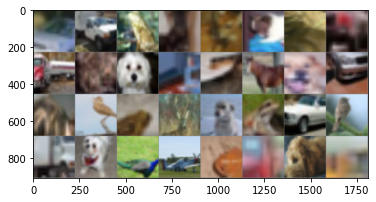

In [29]:
batch_show(trainloader)

In [0]:
from torchvision import models

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg = models.vgg16_bn()

In [31]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [32]:
num_classes = 10
in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier[:-1])
mod_classifier.extend([nn.Linear(in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [0]:
vgg.classifier = nn.Sequential(*mod_classifier)

In [34]:
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [0]:
from torch import optim
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.005)
vgg = vgg.to(device)

In [0]:
def evaluation(dataloader):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = vgg(inputs)
    _, pred = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (pred == labels).sum().item()

  return (correct/total * 100)

In [0]:
epochs = 10
num_batch = np.ceil(50000/bs)

for epoch in range(epochs):
  for i, data in enumerate(trainloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()
    outputs = vgg(inputs)

    loss = loss_fn(outputs, labels)

    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i%100 == 0:
      print('Batch iteration: %d/%d \t Loss: %0.2f' % (i+1, num_batch, loss.item()))

  print('Epoch %d/%d \t Test acc: %0.2f \t Train acc: %0.2f' % (epoch, epochs, evaluation(testloader), evaluation(trainloader)))


### Pretrained VGG16

In [0]:
vgg = models.vgg16_bn(pretrained=True)

In [0]:
for params in vgg.parameters():
  params.requires_grad = False

In [60]:
print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [0]:
vgg.classifier[6] = nn.Linear(in_features, num_classes)

In [62]:
for params in vgg.parameters():
  if params.requires_grad == True:
      print(params.shape)

torch.Size([10, 4096])
torch.Size([10])


In [63]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
vgg = vgg.to(device)

In [0]:
epochs = 10
num_batch = np.ceil(50000/bs)

for epoch in range(epochs):
  for i, data in enumerate(trainloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()
    outputs = vgg(inputs)

    loss = loss_fn(outputs, labels)

    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache()

    if i%100 == 0:
      print('Batch iteration: %d/%d \t Loss: %0.2f' % (i+1, num_batch, loss.item()))

  print('Epoch %d/%d \t Test acc: %0.2f \t Train acc: %0.2f' % (epoch, epochs, evaluation(testloader), evaluation(trainloader)))